In [30]:
!pip install legend-pydataobj

In [31]:
from lgdo import lh5
import awkward as ak
import glob
import hist
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 3)

In [32]:
import h5py

filename = "MJD_Train_1.hdf5"
with h5py.File(filename, "r") as f:
    print("Keys at root:", list(f.keys()))
    # For example you might see something like: "raw_waveform", "energy_label", "psd_label_low_avse", ...
    for key in f.keys():
        print(key, f[key].shape, f[key].dtype)


Keys at root: ['detector', 'energy_label', 'id', 'psd_label_dcr', 'psd_label_high_avse', 'psd_label_low_avse', 'psd_label_lq', 'raw_waveform', 'run_number', 'tp0']
detector (65000,) int64
energy_label (65000,) float64
id (65000,) int64
psd_label_dcr (65000,) bool
psd_label_high_avse (65000,) bool
psd_label_low_avse (65000,) bool
psd_label_lq (65000,) bool
raw_waveform (65000, 3800) float64
run_number (65000,) int64
tp0 (65000,) int64


In [33]:
import h5py
import numpy as np

filename = "MJD_Train_1.hdf5"

with h5py.File(filename, "r") as f:
    # Check available keys first
    print("Keys:", list(f.keys()))
    
    waveforms = f["raw_waveform"][:]                
    sse_label = f["psd_label_low_avse"][:]
    energy_label = f["energy_label"][:]

# Combine conditions: single-site AND energy between 30 and 1500 keV
combined_indices = np.where(
    (sse_label == 1) & (energy_label >= 30) & (energy_label <= 1500)
)[0]

# Extract the waveforms and energies
selected_waveforms = waveforms[combined_indices]
selected_energies = energy_label[combined_indices]

print(f"Found {len(selected_waveforms)} single-site events in 30–1500 keV range")

Keys: ['detector', 'energy_label', 'id', 'psd_label_dcr', 'psd_label_high_avse', 'psd_label_low_avse', 'psd_label_lq', 'raw_waveform', 'run_number', 'tp0']
Found 25403 single-site events in 30–1500 keV range


Computed SNRs for 25403 single-site events


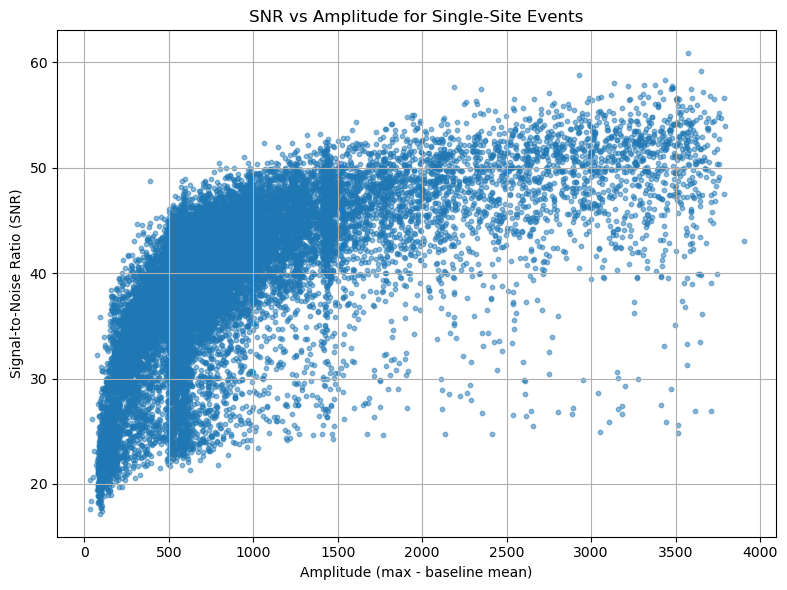

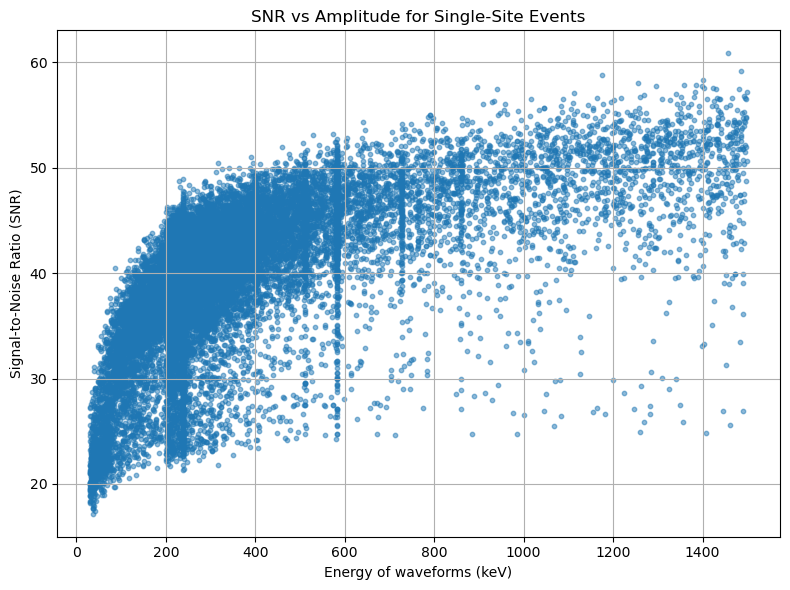

In [34]:
# Choose baseline region (first 1000 samples)
baseline_region = slice(0, 1000)

# Compute SNR and amplitude for all single-site waveforms
snr_list = []
amp_list = []
energy_list = []

for idx in range(len(selected_waveforms)):
    wf = selected_waveforms[idx]
    baseline = wf[baseline_region]
    
    baseline_mean = np.mean(baseline)
    baseline_std = np.std(baseline)
    amplitude = np.max(wf) - baseline_mean
    energy = selected_energies[idx]
    # Avoid division by zero
    snr = 20 * np.log10(amplitude / baseline_std) if baseline_std > 0 else np.nan
    
    amp_list.append(amplitude)
    snr_list.append(snr)
    energy_list.append(energy)
    
snr_list = np.array(snr_list)
amp_list = np.array(amp_list)
energy_list = np.array(energy_list)

print(f"Computed SNRs for {len(snr_list)} single-site events")

# Plot SNR vs Amplitude
plt.figure(figsize=(8, 6))
plt.scatter(amp_list, snr_list, s=10, alpha=0.5)
plt.xlabel("Amplitude (max - baseline mean)")
plt.ylabel("Signal-to-Noise Ratio (SNR)")
plt.title("SNR vs Amplitude for Single-Site Events")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot SNR vs Energy
plt.figure(figsize=(8, 6))
plt.scatter(energy_list, snr_list, s=10, alpha=0.5)
plt.xlabel("Energy of waveforms (keV)")
plt.ylabel("Signal-to-Noise Ratio (SNR)")
plt.title("SNR vs Amplitude for Single-Site Events")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Define baseline region (first 1000 samples)
baseline_region = slice(0, 1000)

# Sort indices by SNR
sorted_indices = np.argsort(snr_list)
low_snr_indices = sorted_indices[:5000]
high_snr_indices = sorted_indices[-5000:]

# # Plot 10 lowest SNR waveforms
# plt.figure(figsize=(10, 6))
# for i, idx in enumerate(low_snr_indices):
#     wf = selected_waveforms[idx]
#     plt.plot(wf, label=f"Low SNR #{i} ({snr_list[idx]:.1f})")
# plt.xlabel("Sample index")
# plt.ylabel("Amplitude")
# plt.title("10 Single-Site Waveforms with Lowest SNR")
# plt.legend(fontsize=8)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Plot 10 highest SNR waveforms
# plt.figure(figsize=(10, 6))
# for i, idx in enumerate(high_snr_indices):
#     wf = selected_waveforms[idx]
#     plt.plot(wf, label=f"High SNR #{i} ({snr_list[idx]:.1f})")
# plt.xlabel("Sample index")
# plt.ylabel("Amplitude")
# plt.title("10 Single-Site Waveforms with Highest SNR")
# plt.legend(fontsize=8)
# plt.grid(True)
# plt.tight_layout()
# plt.show()



Keys: ['detector', 'energy_label', 'id', 'psd_label_dcr', 'psd_label_high_avse', 'psd_label_low_avse', 'psd_label_lq', 'raw_waveform', 'run_number', 'tp0']
Found 29087 single-site events
Found 7948 SSEs with SNR < 200 and amplitude > 6000


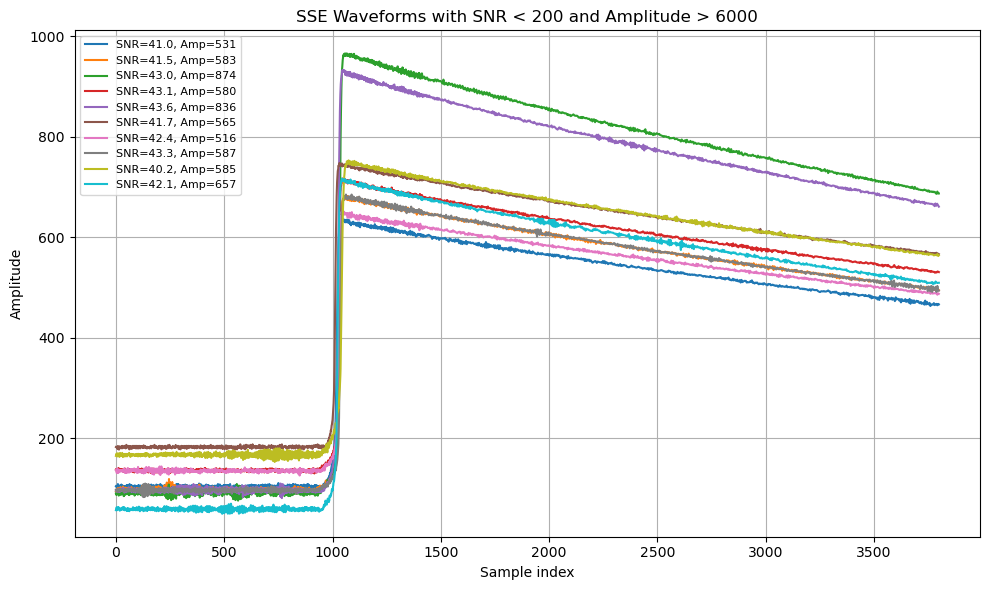

In [36]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

filename = "MJD_Train_1.hdf5"

with h5py.File(filename, "r") as f:
    print("Keys:", list(f.keys()))
    waveforms = f["raw_waveform"][:]                # shape: (N_events, 3800)
    sse_label = f["psd_label_low_avse"][:]          # 1 = single-site, 0 = multi-site

# Find single-site event indices
sse_indices = np.where(sse_label == 1)[0]
print(f"Found {len(sse_indices)} single-site events")

# Define baseline region
baseline_region = slice(0, 1000)

# Compute SNR and amplitude for all SSEs
snr_list = []
amp_list = []

for idx in sse_indices:
    wf = waveforms[idx]
    baseline = wf[baseline_region]
    baseline_mean = np.mean(baseline)
    baseline_std = np.std(baseline)
    amplitude = np.max(wf) - baseline_mean
    snr = 20 * np.log10(amplitude / baseline_std) if baseline_std > 0 else np.nan
    amp_list.append(amplitude)
    snr_list.append(snr)

snr_list = np.array(snr_list)
amp_list = np.array(amp_list)

# Find indices that meet your criteria
mask = (snr_list > 40) & (amp_list < 1000)
selected_indices = np.where(mask)[0]
print(f"Found {len(selected_indices)} SSEs with SNR < 200 and amplitude > 6000")

# Plot up to 10 examples (or all if fewer)
plt.figure(figsize=(10, 6))
for i, idx in enumerate(selected_indices[:10]):
    wf = waveforms[sse_indices[idx]]
    plt.plot(wf, label=f"SNR={snr_list[idx]:.1f}, Amp={amp_list[idx]:.0f}")

plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.title("SSE Waveforms with SNR < 200 and Amplitude > 6000")
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


Computed v_per_count = 1.220703e-04 V/count from ADC settings
Johnson RMS voltage sigma_V = 2.878e-06 V
Equivalent sigma in ADC counts = 0.024 counts (RMS)
SNR before (examples): [170.23 170.23 170.24 170.26 170.27 170.29]
SNR after  (examples): [170.22 170.24 170.19 170.28 170.19 170.3 ]


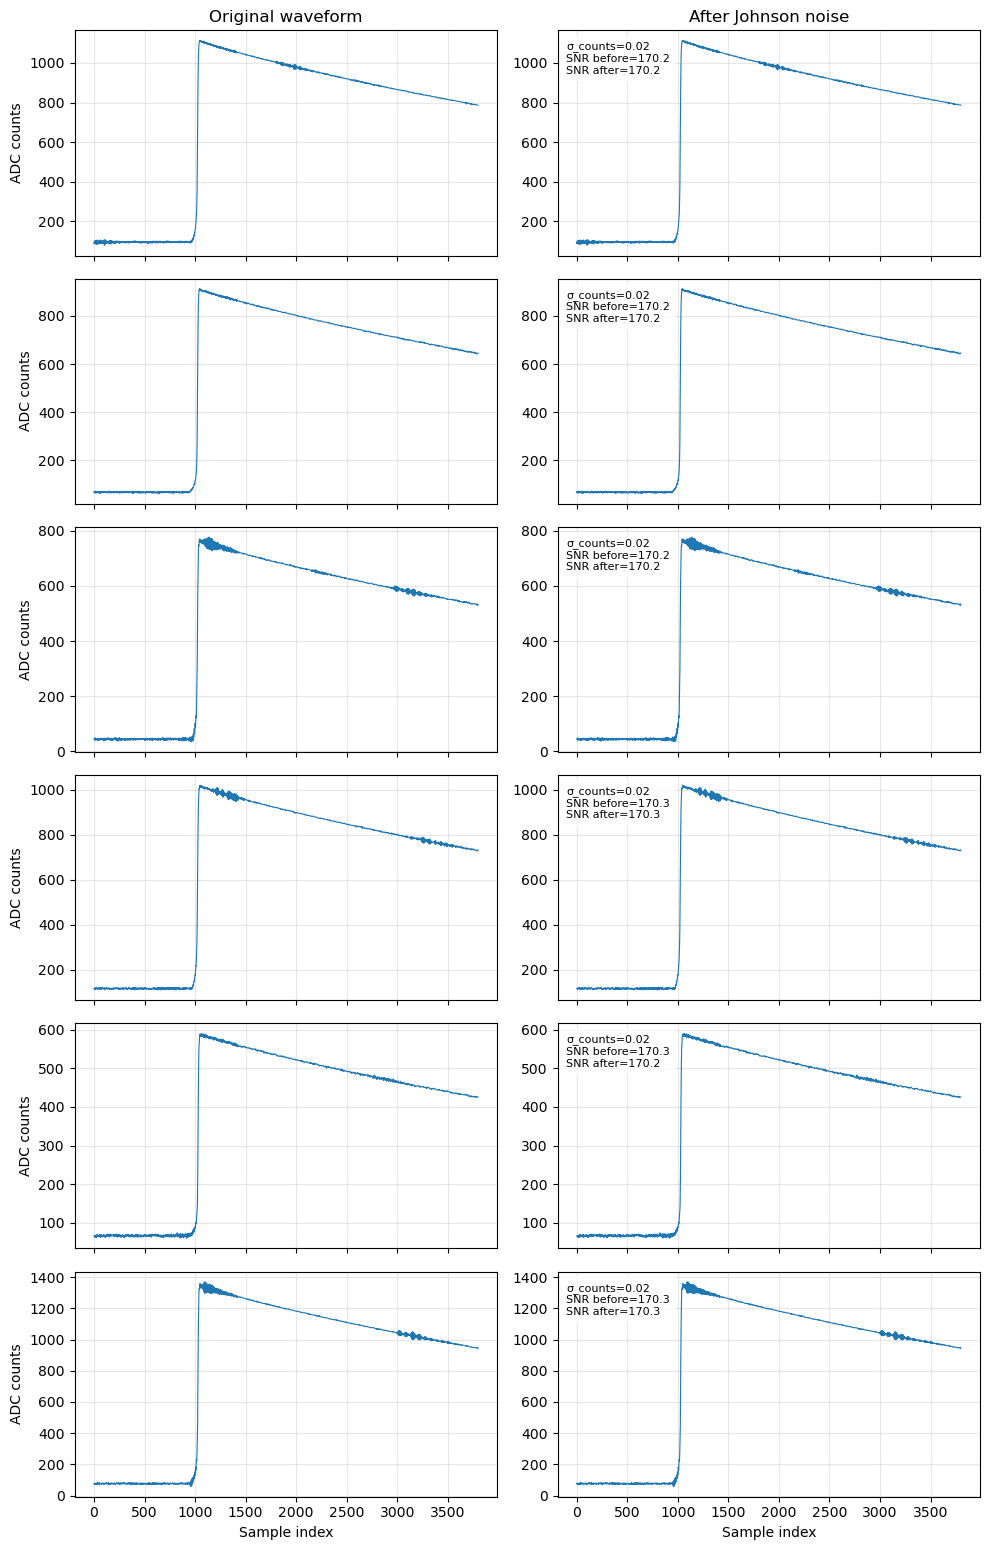

In [37]:
# Physics / electronics parameters (fill these)
kB = 1.380649e-23    # Boltzmann constant (J/K)
T = 300.0            # Temperature in Kelvin (e.g., 300 K for room)
R = 50.0             # Equivalent source resistance in Ohms (Ω)
Fs = 100e9           # Sampling frequency in Hz (replace with your sampling rate)
# Effective analog bandwidth (Hz) — best to use the analog filter cutoff (not necessarily Fs/2)
B = 10e6             


v_per_count = None   

# Option B: compute v_per_count from ADC range and resolution
adc_bits = 14        # ADC resolution in bits (set to None if not applicable)
adc_v_range = 2.0    # full-scale voltage range (peak-to-peak or ±?), e.g. 2.0 Vpp or 2*Vref for bipolar
adc_range_is_pp = True

# Baseline region used for SNR calculation (samples before pulse)
baseline_region = slice(0, 1000) 
n_plot = 6

if v_per_count is None:
    if (adc_bits is None) or (adc_v_range is None):
        raise ValueError("Either set v_per_count or provide adc_bits and adc_v_range.")
    # number of levels
    n_levels = 2 ** adc_bits
    if adc_range_is_pp:
        # peak-to-peak range distributed across n_levels
        v_per_count = adc_v_range / n_levels
    else:
        # ±Vref: full-scale is 2*Vref but user gave Vref maybe; we assume adc_v_range represents ±Vref range
        v_per_count = (2.0 * adc_v_range) / n_levels
    print(f"Computed v_per_count = {v_per_count:.6e} V/count from ADC settings")

# Compute Johnson RMS voltage and convert to ADC counts
sigma_V = np.sqrt(4.0 * kB * T * R * B)   # [V RMS]
sigma_counts = sigma_V / v_per_count      # [ADC counts RMS]

print(f"Johnson RMS voltage sigma_V = {sigma_V:.3e} V")
print(f"Equivalent sigma in ADC counts = {sigma_counts:.3f} counts (RMS)")

high_waveforms = selected_waveforms[high_snr_indices]  # shape (M, L)

# Function to compute SNR using baseline_region and peak
def compute_snr(wf, baseline_region=baseline_region):
    baseline = wf[baseline_region]
    mu = np.mean(baseline)
    sigma = np.std(baseline)
    amp = np.max(wf) - mu
    return amp / sigma if sigma > 0 else np.nan

# Add Johnson noise (Gaussian with sigma_counts) to each waveform
rng = np.random.default_rng()  # use new numpy RNG
noisy_waveforms = high_waveforms + rng.normal(loc=0.0, scale=sigma_counts, size=high_waveforms.shape)

# Compute SNR before/after for examples
snr_before = np.array([compute_snr(w) for w in high_waveforms])
snr_after  = np.array([compute_snr(w) for w in noisy_waveforms])

print("SNR before (examples):", np.round(snr_before[:n_plot], 2))
print("SNR after  (examples):", np.round(snr_after[:n_plot], 2))

# Plot a few examples: original vs noisy
n_show = min(n_plot, high_waveforms.shape[0])
fig, axs = plt.subplots(n_show, 2, figsize=(10, 2.6 * n_show), sharex=True)
for i in range(n_show):
    wf = high_waveforms[i]
    wf_noisy = noisy_waveforms[i]
    axs[i,0].plot(wf, linewidth=0.8)
    axs[i,0].set_ylabel("ADC counts")
    if i == 0:
        axs[i,0].set_title("Original waveform")
    axs[i,0].grid(alpha=0.3)
    axs[i,1].plot(wf_noisy, linewidth=0.8)
    if i == 0:
        axs[i,1].set_title("After Johnson noise")
    axs[i,1].text(0.02, 0.95, f"σ_counts={sigma_counts:.2f}\nSNR before={snr_before[i]:.1f}\nSNR after={snr_after[i]:.1f}",
                  transform=axs[i,1].transAxes, fontsize=8, verticalalignment='top',
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    axs[i,1].grid(alpha=0.3)

axs[-1,0].set_xlabel("Sample index")
axs[-1,1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()



Computed v_per_count = 1.220703e-04 V/count
Johnson RMS noise = 1.287e-06 V  =  0.01 counts RMS
SNR before (examples): [170.23 170.23 170.24 170.26 170.27 170.29]
SNR after  (examples): [82.69 79.42 79.1  76.78 76.02 79.85]


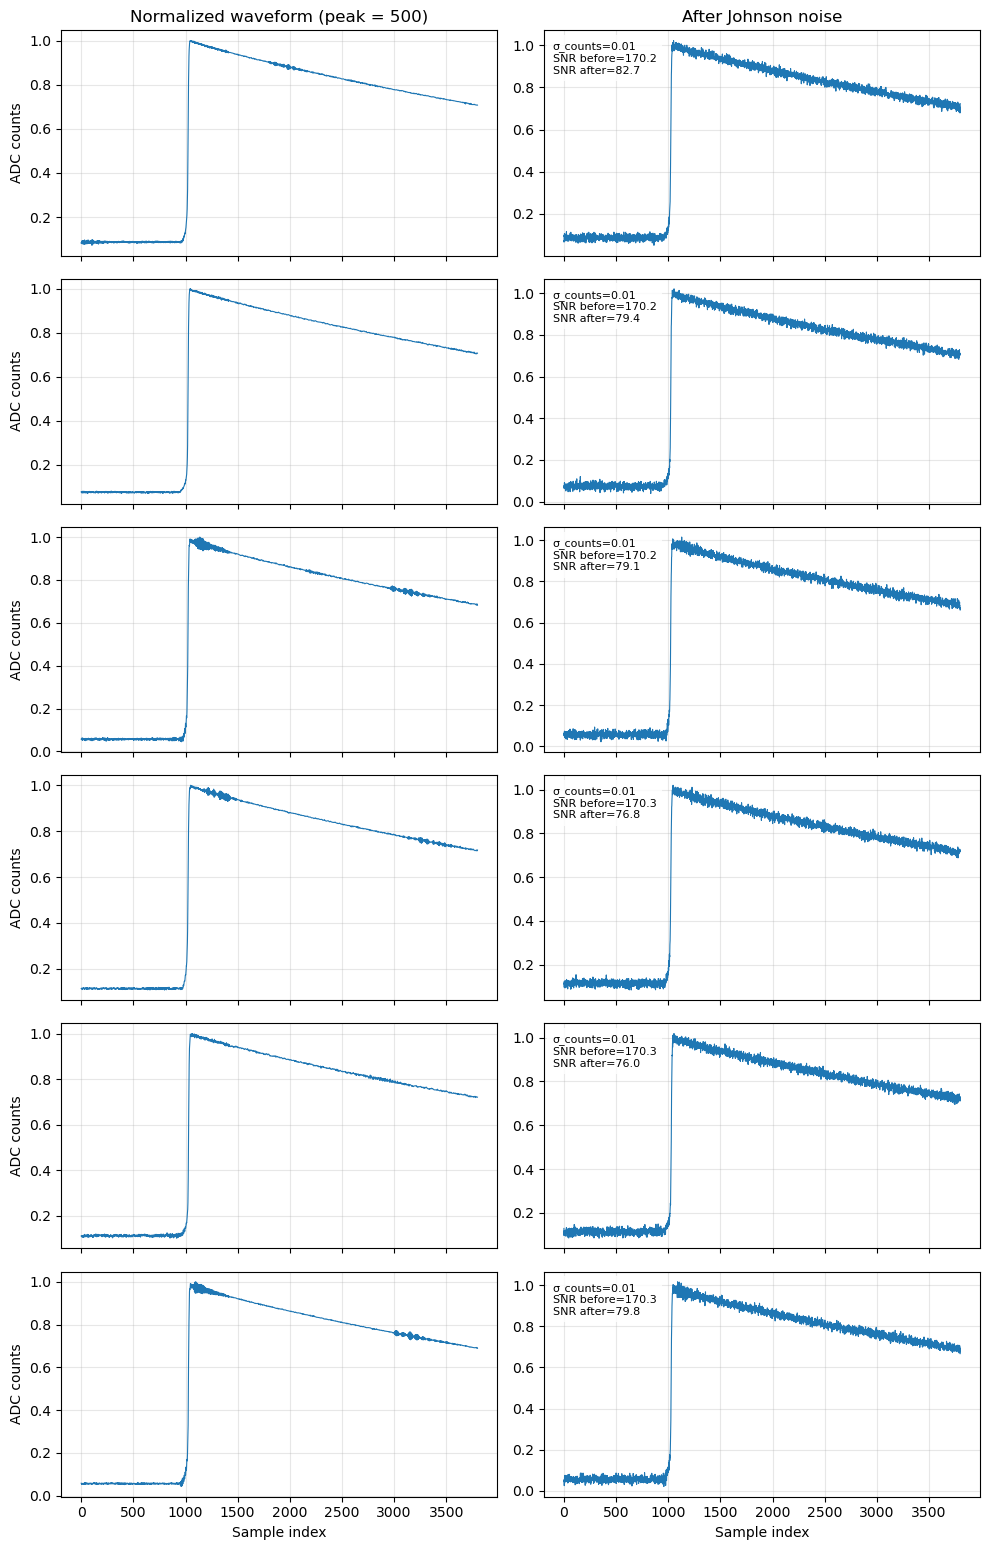

In [38]:
# Physics / electronics parameters
kB = 1.380649e-23    # Boltzmann constant [J/K]
T = 300.0            # Temperature [K]
R = 10.0             # Resistance [Ω]
Fs = 100e9           # Sampling rate [Hz]
B = 10e6             # Analog bandwidth [Hz]

# ADC scaling (same as before)
v_per_count = None   # leave None to compute from ADC params
adc_bits = 14
adc_v_range = 2.0    # volts (peak-to-peak or ±, see next line)
adc_range_is_pp = True

# Normalization target
target_peak = 1.0  

# Baseline region used for SNR computation
baseline_region = slice(0, 1000)
n_plot = 6


if v_per_count is None:
    n_levels = 2 ** adc_bits
    v_per_count = adc_v_range / n_levels if adc_range_is_pp else (2 * adc_v_range) / n_levels
    print(f"Computed v_per_count = {v_per_count:.6e} V/count")

# Compute Johnson noise amplitude
sigma_V = np.sqrt(4.0 * kB * T * R * B)
sigma_counts = sigma_V / v_per_count
print(f"Johnson RMS noise = {sigma_V:.3e} V  =  {sigma_counts:.2f} counts RMS")

# Select waveforms
if 'selected_waveforms' not in globals():
    raise RuntimeError("selected_waveforms missing")
if 'high_snr_indices' not in globals():
    raise RuntimeError("high_snr_indices missing")

high_waveforms = selected_waveforms[high_snr_indices].copy()

# Normalize each waveform to have max = target_peak 
for i in range(len(high_waveforms)):
    max_val = np.max(high_waveforms[i])
    if max_val != 0:
        high_waveforms[i] = high_waveforms[i] * (target_peak / max_val)

# Helper to compute SNR
def compute_snr(wf, baseline_region=baseline_region):
    baseline = wf[baseline_region]
    mu = np.mean(baseline)
    sigma = np.std(baseline)
    amp = np.max(wf) - mu
    return amp / sigma if sigma > 0 else np.nan

# Add Johnson noise
rng = np.random.default_rng()
noisy_waveforms = high_waveforms + rng.normal(0.0, sigma_counts, size=high_waveforms.shape)

# Compute SNRs
snr_before = np.array([compute_snr(w) for w in high_waveforms])
snr_after  = np.array([compute_snr(w) for w in noisy_waveforms])

print("SNR before (examples):", np.round(snr_before[:n_plot], 2))
print("SNR after  (examples):", np.round(snr_after[:n_plot], 2))

# Plot comparison 
n_show = min(n_plot, high_waveforms.shape[0])
fig, axs = plt.subplots(n_show, 2, figsize=(10, 2.6 * n_show), sharex=True)
for i in range(n_show):
    wf = high_waveforms[i]
    wf_noisy = noisy_waveforms[i]
    axs[i,0].plot(wf, linewidth=0.8)
    axs[i,0].set_ylabel("ADC counts")
    if i == 0:
        axs[i,0].set_title("Normalized waveform (peak = 500)")
    axs[i,0].grid(alpha=0.3)
    axs[i,1].plot(wf_noisy, linewidth=0.8)
    if i == 0:
        axs[i,1].set_title("After Johnson noise")
    axs[i,1].text(0.02, 0.95, f"σ_counts={sigma_counts:.2f}\nSNR before={snr_before[i]:.1f}\nSNR after={snr_after[i]:.1f}",
                  transform=axs[i,1].transAxes, fontsize=8, verticalalignment='top',
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    axs[i,1].grid(alpha=0.3)

axs[-1,0].set_xlabel("Sample index")
axs[-1,1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()

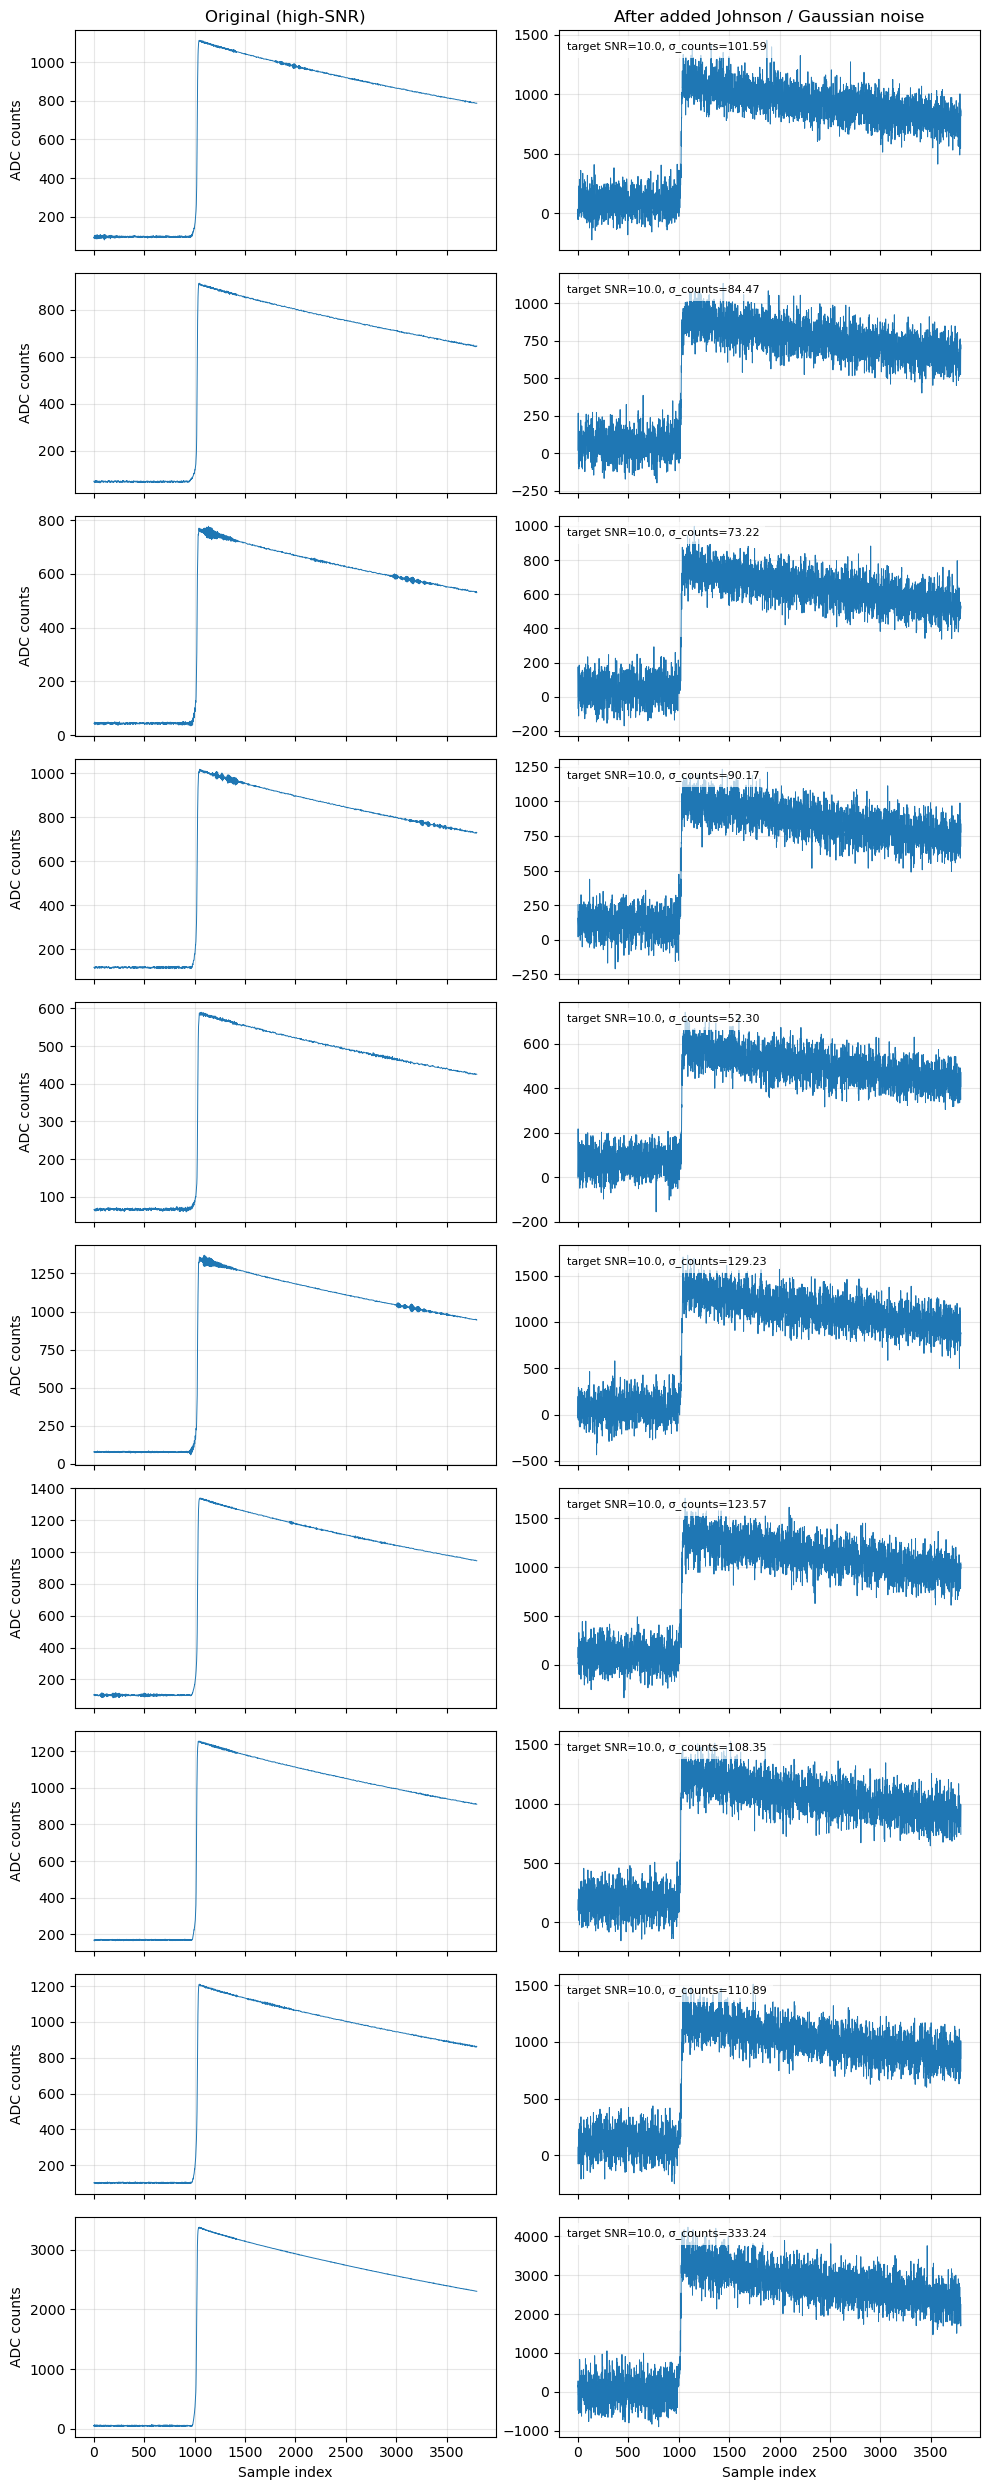

SNR before (first examples): [170.23099049 170.23258454 170.24241926 170.25801705 170.27063181
 170.28788833 170.31426104 170.33098155 170.33640684 170.35925293]
SNR after  (first examples): [12.49453021 12.54376843 12.78095982 12.41509254 13.38462493 12.36887968
 12.8281602  12.41124395 11.58306661 13.07884081]


In [39]:
# Choose method: "physics" or "target_snr"
method = "target_snr"  

# Physics parameters (only used if method == "physics")
kB = 1.380649e-23   # J/K
T = 300.0           # Kelvin
R = 100.0            # Ohm

Fs = 100e9          # sampling frequency (Hz) - example; set to true sampling freq if known
B = Fs / 2.0        # naive bandwidth estimate (Hz). If known, use the anti-alias filter bandwidth instead.

# ADC scaling: volts per ADC count. Set to your system value.
v_per_count = 1e-3  # V per ADC count (example: 1 mV per ADC). Change to your real scale.

# Target SNR (only used if method == "target_snr")
SNR_target = 10.0   # desired SNR for the added noise 

# Choose the high-SNR waveforms (use your existing index array)
high_waveforms = selected_waveforms[high_snr_indices]

# Function to add physics-based Johnson noise (converted to ADC counts)
def add_physics_johnson_noise(wf, kB, T, R, B, v_per_count):
    sigma_V = np.sqrt(4.0 * kB * T * R * B)   # RMS voltage
    sigma_counts = sigma_V / v_per_count
    noise = np.random.normal(loc=0.0, scale=sigma_counts, size=wf.shape)
    return wf + noise, sigma_counts

# Function to add Gaussian noise to produce a target SNR (defined using peak amplitude)
def add_target_snr_noise(wf, baseline_region=slice(0,1000), snr_target=50.0):
    baseline = wf[baseline_region]
    baseline_mean = np.mean(baseline)
    amplitude = np.max(wf) - baseline_mean
    sigma = amplitude / snr_target if snr_target > 0 else 0.0
    noise = np.random.normal(loc=0.0, scale=sigma, size=wf.shape)
    return wf + noise, sigma

# Apply noise to each high-SNR waveform and plot
n_plot = min(10, len(high_waveforms))
fig, axes = plt.subplots(n_plot, 2, figsize=(10, 2.5 * n_plot), sharex=True)
for i in range(n_plot):
    wf = high_waveforms[i]
    if method == "physics":
        wf_noisy, sigma_used = add_physics_johnson_noise(wf, kB, T, R, B, v_per_count)
        info = f"physics σ_counts={sigma_used:.2f}"
    else: # target_snr
        wf_noisy, sigma_used = add_target_snr_noise(wf, baseline_region=slice(0,1000), snr_target=SNR_target)
        info = f"target SNR={SNR_target:.1f}, σ_counts={sigma_used:.2f}"
    
    # Plot original
    ax_orig = axes[i, 0]
    ax_orig.plot(wf, linewidth=0.7)
    ax_orig.set_ylabel("ADC counts")
    if i == 0:
        ax_orig.set_title("Original (high-SNR)")
    ax_orig.grid(True, alpha=0.3)
    
    # Plot noisy
    ax_noisy = axes[i, 1]
    ax_noisy.plot(wf_noisy, linewidth=0.7)
    if i == 0:
        ax_noisy.set_title("After added Johnson / Gaussian noise")
    ax_noisy.text(0.02, 0.95, info, transform=ax_noisy.transAxes, fontsize=8,
                  verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax_noisy.grid(True, alpha=0.3)

axes[-1, 0].set_xlabel("Sample index")
axes[-1, 1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()

# Optional: show SNR before and after (computed the same way as your baseline SNR)
def compute_snr(wf, baseline_region=slice(0,1000)):
    baseline = wf[baseline_region]
    mu = np.mean(baseline)
    sigma = np.std(baseline)
    amp = np.max(wf) - mu
    return amp / sigma if sigma > 0 else np.nan

# compute summary
snr_before = [compute_snr(w) for w in high_waveforms[:n_plot]]
snr_after = [compute_snr((add_physics_johnson_noise(w, kB, T, R, B, v_per_count)[0] if method=="physics"
                          else add_target_snr_noise(w, baseline_region=slice(0,1000), snr_target=SNR_target)[0]))
             for w in high_waveforms[:n_plot]]

print("SNR before (first examples):", np.array(snr_before))
print("SNR after  (first examples):", np.array(snr_after))


In [40]:
# starting from here: Basic NN

In [46]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib
import matplotlib.pyplot as plt

import torch as torch
import torch.nn as nn

In [47]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [48]:
clean = np.array(high_waveforms, dtype=np.float32)

# Generate noisy versions using your existing function
noisy = []
for wf in clean:
    if method == "physics":
        noisy_wf, _ = add_physics_johnson_noise(
            wf, kB, T, R, B, v_per_count
        )
    else:
        noisy_wf, _ = add_target_snr_noise(
            wf, baseline_region=slice(0,1000),
            snr_target=SNR_target
        )
    noisy.append(noisy_wf)

noisy = np.array(noisy, dtype=np.float32)

print("Clean shape:", clean.shape)
print("Noisy shape:", noisy.shape)

Clean shape: (5000, 3800)
Noisy shape: (5000, 3800)


In [49]:
X_train, X_temp, y_train, y_temp = train_test_split(
    noisy, clean, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (3500, 3800)
Val:   (750, 3800)
Test:  (750, 3800)


In [51]:
L = clean.shape[1]   # waveform length

model = models.Sequential([
    layers.Input(shape=(L,)),
    layers.Dense(1024, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dense(L, activation="linear")   # output = denoised waveform
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │     3,892,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3800)           │     3,895,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,886,424 (37.71 MB)

 Trainable params: 9,886,424 (37.71 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"\nTest MSE: {test_loss:.6f}, Test MAE: {test_mae:.6f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2204362.5000 - mae: 1177.1550

Test MSE: 2204362.500000, Test MAE: 1177.155029


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


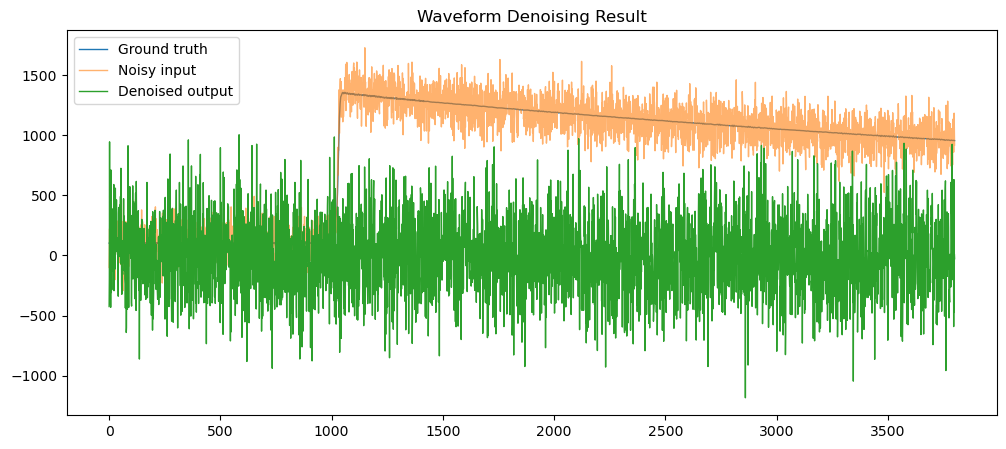

In [53]:
idx = 0
wf_noisy = X_test[idx]
wf_clean = y_test[idx]
wf_denoised = model.predict(wf_noisy.reshape(1, -1))[0]

plt.figure(figsize=(12,5))
plt.plot(wf_clean, label="Ground truth", linewidth=1)
plt.plot(wf_noisy, label="Noisy input", alpha=0.6, linewidth=1)
plt.plot(wf_denoised, label="Denoised output", linewidth=1)
plt.legend()
plt.title("Waveform Denoising Result")
plt.show()
